In [1]:
import numpy as np
import copy
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii
from astropy import wcs
from astropy.io import fits
from astropy.table import QTable, Table, Column,vstack

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
#matplotlib.rc_file(\"../../templates/matplotlibrc\")
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# Astropy Regions (but standalone package installed with pip)
import regions

In [2]:
def pfs_vertices(ctr_coord,pa=0):
    # Given a field center (SkyCoord object), return the 6 vertices of a Subaru PFS field. Optional PA is in degrees
    d = 41.4*u.arcmin 
    vertices=[]
    for i in range(6):
        angularoffset = np.pi / 3 * i *u.radian + pa*u.deg
        vertices.append(ctr_coord.directional_offset_by(angularoffset,d))
    return SkyCoord(vertices)

In [3]:
ge_fields_in = ascii.read('pfs_ge_centers.txt')

fields   = ge_fields_in['fieldname']
subfield = ge_fields_in['subfieldno']
ra_field = ge_fields_in['ra']
dec_field= ge_fields_in['dec']

ctr_coords = SkyCoord(ra=ra_field*u.deg, dec=dec_field*u.deg, frame='icrs')

In [4]:
fieldstr = 'COSMOS'
getfields = fields==fieldstr
ctrs_here = ctr_coords[getfields]
n_pointings=np.sum(getfields)

# Compute a very rough center position for these pointings, as the average of the pointing centers
rough_ctr = SkyCoord(ra=np.mean(ctrs_here.ra.to(u.deg)), dec=np.mean(ctrs_here.dec.to(u.deg)), frame='icrs')

print('Rough center for '+fieldstr+': '+rough_ctr.ra.to_string(u.hour)+rough_ctr.dec.to_string(u.deg,alwayssign=True))

Rough center for COSMOS: 10h00m25.6158s+2d06m28.8659s


In [5]:
wcstmp = wcs.WCS(naxis=2)
wcstmp.wcs.crpix=[1,1]
wcstmp.wcs.crval=[148.547008, 0.662545] # eyeballed off hscMap
wcstmp.wcs.cdelt=[0.001666667, 0.00166667]
wcstmp.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcstmp.wcs.radesys='ICRS'
wcstmp.wcs.equinox=2000.00

ctr1 = ctr_coords[9]

/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 

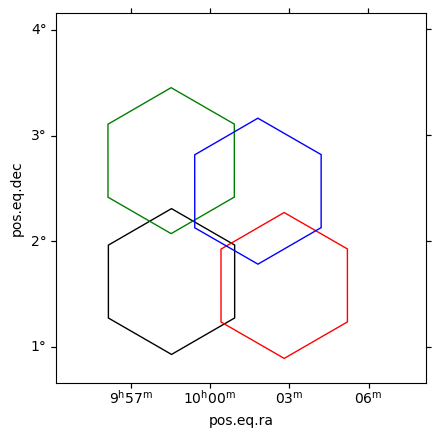

In [6]:
all_regions = []

# Des
pa_list = [0,0,0,0]

# This creates the Regions (i.e. list of regions)
for tmpcoord,pa_tmp in zip(ctr_coords[getfields],pa_list):
    all_regions.append(regions.PolygonSkyRegion(vertices=pfs_vertices(tmpcoord,pa=pa_tmp)))

# This is the composite region of all pointings
for ii in range(n_pointings-1):
    if ii == 0:
        comb_region = all_regions[0]
    comb_region = comb_region | all_regions[ii+1]

pix_reg_allcosmos = comb_region.to_pixel(wcstmp)

colorlist=['black','green','red','blue']

ax=plt.subplot(projection=wcstmp)
ax.set_xlim(0,2100)
ax.set_ylim(0,2100)
for reg_tmp,colortmp in zip(all_regions,colorlist):
    pix_reg_tmp = reg_tmp.to_pixel(wcstmp)
    ax.add_artist(pix_reg_tmp.as_artist(color=colortmp))
ax.set_aspect('equal')

In [8]:
print(rough_ctr.ra.to_string(u.hour)+rough_ctr.dec.to_string(u.deg,alwayssign=True))


10h00m25.6158s+2d06m28.8659s
